In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense 
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression

In [8]:
df = pd.read_csv(r"C:\Users\ASUS\AppData\Roaming\Bulldog\getTraf_data\4 month vol.csv")
df

date  hour  6908  6909  6910  Total Vol
0     1/1/2022     0   259   288    83        630
1     1/1/2022     1   223   296    77        596
2     1/1/2022     2   135   243    84        462
3     1/1/2022     3   103   175    46        324
4     1/1/2022     4    96    95     7        198
...        ...   ...   ...   ...   ...        ...
2899  1/5/2022    19   722   959   536       2217
2900  1/5/2022    20   583   791   376       1750
2901  1/5/2022    21   503   575   240       1318
2902  1/5/2022    22   394   447   143        984
2903  1/5/2022    23   260   341   105        706

[2904 rows x 6 columns]

In [51]:
X = df[['6908','6909', '6910']]
y = df['Total Vol']

In [52]:
def sum(val):
    if 0 <= val < 500:
        return 'Volume between 0-500'
    elif 500 <= val < 1000:
        return 'Volume between 500-1000'
    elif 1000 <= val < 1500:
        return 'Volume between 1000-1500'
    elif 1500 <= val < 2000:
        return 'Volume between 1500-2000'
    elif 2000 <= val < 2500:
        return 'Volume between 2000-2500'
    elif 2500 <= val < 3000:
        return 'Volume between 2500-3000'
    else:
        return 'Volume above 3000'

df['V'] = df['Total Vol'].apply(sum)

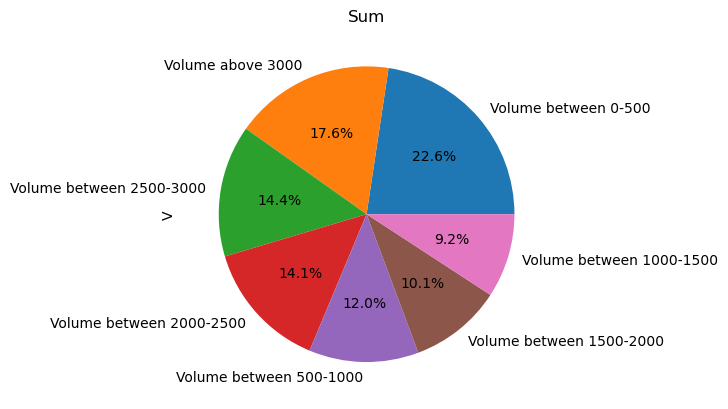

In [53]:
fig, ax = plt.subplots()
df['V'].value_counts().plot(ax=ax, kind='pie', autopct='%1.1f%%')
plt.title('Sum')
plt.show()

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Standardization targets 
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

In [56]:
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [36]:
model = Sequential()
model.add(LSTM(units=40, activation='tanh', input_shape=(1, X_train_reshaped.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [37]:
early_stop = EarlyStopping(monitor='val_loss', patience=20)


In [38]:
# Train LSTM model on the training data
history = model.fit(
    X_train_reshaped, y_train, 
    epochs=60, 
    batch_size=64, 
    verbose=2, 
    validation_split=0.2,  
    callbacks=[early_stop]
)

Epoch 1/60
30/30 - 5s - loss: 0.7471 - val_loss: 0.5217 - 5s/epoch - 175ms/step
Epoch 2/60
30/30 - 0s - loss: 0.4299 - val_loss: 0.2519 - 171ms/epoch - 6ms/step
Epoch 3/60
30/30 - 0s - loss: 0.1765 - val_loss: 0.0754 - 188ms/epoch - 6ms/step
Epoch 4/60
30/30 - 0s - loss: 0.0406 - val_loss: 0.0109 - 185ms/epoch - 6ms/step
Epoch 5/60
30/30 - 0s - loss: 0.0060 - val_loss: 0.0034 - 199ms/epoch - 7ms/step
Epoch 6/60
30/30 - 0s - loss: 0.0032 - val_loss: 0.0033 - 200ms/epoch - 7ms/step
Epoch 7/60
30/30 - 0s - loss: 0.0030 - val_loss: 0.0031 - 185ms/epoch - 6ms/step
Epoch 8/60
30/30 - 0s - loss: 0.0029 - val_loss: 0.0030 - 329ms/epoch - 11ms/step
Epoch 9/60
30/30 - 0s - loss: 0.0027 - val_loss: 0.0029 - 286ms/epoch - 10ms/step
Epoch 10/60
30/30 - 0s - loss: 0.0026 - val_loss: 0.0027 - 180ms/epoch - 6ms/step
Epoch 11/60
30/30 - 0s - loss: 0.0026 - val_loss: 0.0027 - 136ms/epoch - 5ms/step
Epoch 12/60
30/30 - 0s - loss: 0.0023 - val_loss: 0.0025 - 194ms/epoch - 6ms/step
Epoch 13/60
30/30 - 0s -

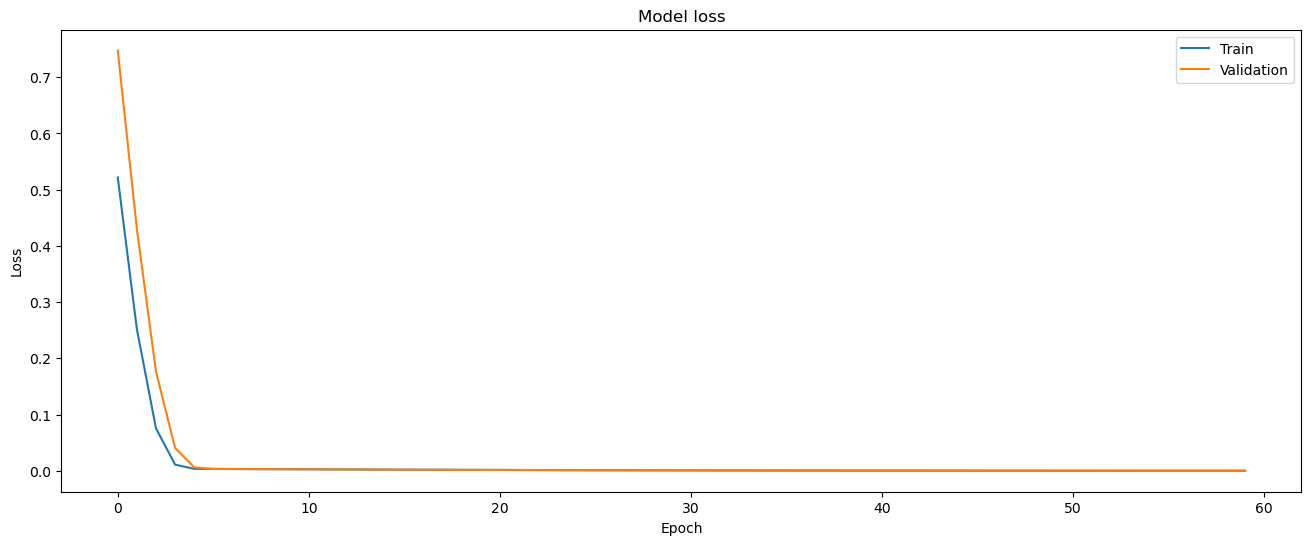

In [39]:
plt.figure(figsize=(16, 6))
plt.plot(history.history['val_loss'])


plt.plot(history.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [40]:
# y predictions
y_train_pred = model.predict(X_train_reshaped)
y_test_pred = model.predict(X_test_reshaped)


19/19 [==============================] - 0s 3ms/step


In [41]:
# Calculate MSE for training and test sets

mse_test = np.mean((y_test - y_test_pred.flatten())**2)
mse_train = np.mean((y_train - y_train_pred.flatten())**2)
print(f'Mean Squared Error train: {mse_test}')
print(f'Mean Squared Error test: {mse_train}')

Mean Squared Error train: 2.0613081040669656
Mean Squared Error test: 1.9995541846912748


In [42]:
# MAPE function
def mean_absolute_percentage_error(y_original, y_pred): 
    y_original, y_pred = np.array(y_original), np.array(y_pred)
    return np.mean(np.abs((y_original - y_pred) / y_original)) * 100


In [43]:
# Calculate MAPE for training and test sets
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print(f'Training MAPE: {mape_train}%')
print(f'Test MAPE: {mape_test}%')

Training MAPE: 2.8863836593397583%
Test MAPE: 2.0533127948801657%


In [44]:
#INVERSING/ PUTTING BACK  the scale
actual_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted_test = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()


In [45]:
#print the results
results_df = pd.DataFrame(data={'Actual': actual_test, 'Predicted': predicted_test})
print(results_df)

     Actual    Predicted
0    1107.0  1095.323120
1     166.0   182.590179
2    1353.0  1350.765625
3    3002.0  3001.917236
4     526.0   513.711243
..      ...          ...
576   177.0   193.254364
577   347.0   343.488251
578   979.0   966.840881
579  2894.0  2893.537598
580  2339.0  2343.499756

[581 rows x 2 columns]


In [46]:
results_df.index = pd.to_datetime(results_df.index)


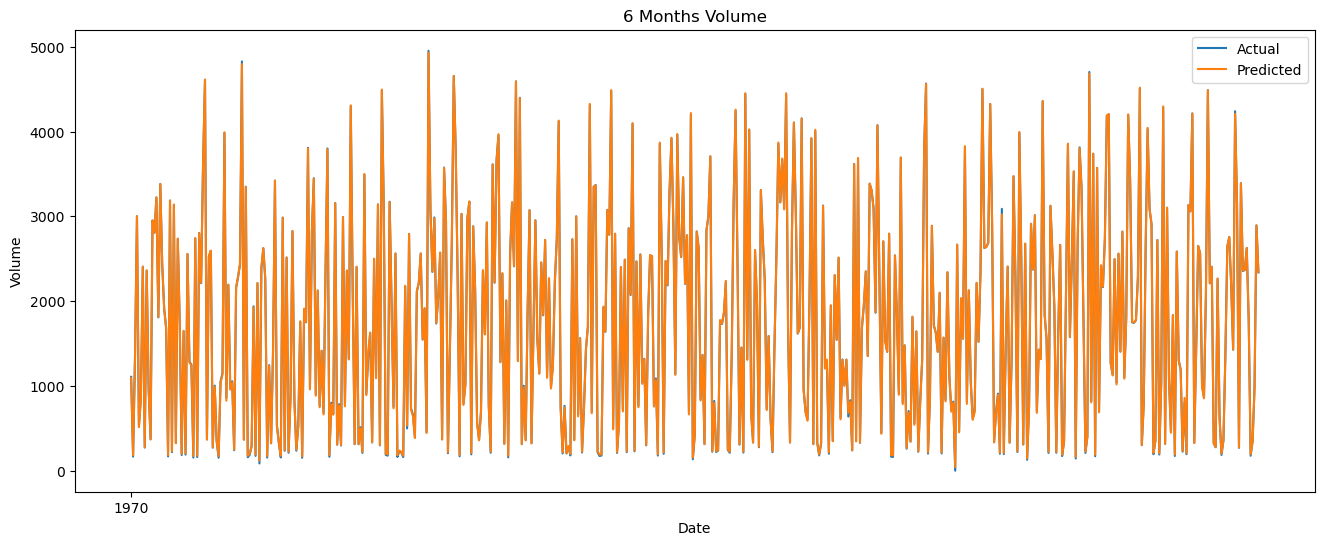

In [48]:
plt.figure(figsize=(16, 6))
plt.plot(results_df['Actual'], label='Actual')
plt.plot(results_df['Predicted'], label='Predicted')


plt.title('6 Months Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()